In [1]:
import sys
import os.path

path = os.path.dirname(os.getcwd())
sys.path.append(path)

# Import modules

In [2]:
from models.unet_2d import UNet2D
from utils.metrics import dice_metric
from utils.loss import soft_dice_loss
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm_notebook

# Create dataloader

In [3]:
class MRI_Dataloader(Dataset):
    def __init__(self, files):
        self.data = files
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x_dir = path + '/data/X/{}.npy' .format(self.data["X"].values[idx])
        y_dir = path + '/data/Y/{}.npy' .format(self.data["Y"].values[idx])
        x = np.load(x_dir)
        y = np.load(y_dir)
        y = y[0] + y[1] + y[2]
        y[y >= 1] = 1
        y = (y).astype(np.uint8)
        return torch.tensor(x).unsqueeze(dim = 0).float(), torch.tensor(y).unsqueeze(dim = 0).float()

# Initialize tensorboard

In [4]:
writer = SummaryWriter('tensorboard/unet_2d')

# Instantiate the model and train

In [5]:
UNet = UNet2D(1, 1, 16).to("cuda:0")

In [6]:
%%capture
Epochs = 50
df = pd.DataFrame(data = {"X": np.arange(1, 10), "Y": np.arange(1, 10)})
Data_Train = DataLoader(MRI_Dataloader(df), 
                        batch_size = 9)
Optimizer = optim.Adam(UNet.parameters(), lr = 1e-3)
for e in range(Epochs):
    total_loss = 0
    dice_score = 0
    for x, y in tqdm_notebook(Data_Train):
        x, y = x.to("cuda:0"), y.to("cuda:0")
        Optimizer.zero_grad()
        y_predicted = F.sigmoid(UNet(x))
        Loss_Value = soft_dice_loss(y_predicted, y)
        Loss_Value.backward()
        Optimizer.step()
        total_loss = total_loss + Loss_Value.item()
        dice_score = dice_score + dice_metric(y.detach().cpu().numpy(), y_predicted.detach().cpu().numpy())
    total_loss = total_loss/df.shape[0]
    dice_score = dice_score
    #saving metrics
    writer.add_scalar('Training loss', total_loss, e)
    writer.add_scalar('Training dice score', dice_score, e)
    #saving model weights distribution
    writer.add_histogram("Encoder_1.Conv1.weights", UNet.Encoder_1[0].weight, e)
    writer.add_histogram("Encoder_1.Conv1.weights", UNet.Encoder_1[3].weight, e)
    writer.add_histogram("Encoder_2.Conv1.weights", UNet.Encoder_2[0].weight, e)
    writer.add_histogram("Encoder_2.Conv1.weights", UNet.Encoder_2[3].weight, e)
    writer.add_histogram("Encoder_3.Conv1.weights", UNet.Encoder_4[0].weight, e)
    writer.add_histogram("Encoder_3.Conv1.weights", UNet.Encoder_4[3].weight, e)
    writer.add_histogram("Encoder_4.Conv1.weights", UNet.Encoder_4[0].weight, e)
    writer.add_histogram("Encoder_4.Conv1.weights", UNet.Encoder_4[3].weight, e)
    writer.add_histogram("Encoder_5.Conv1.weights", UNet.Encoder_5[0].weight, e)
    writer.add_histogram("Encoder_5.Conv1.weights", UNet.Encoder_5[3].weight, e)
    writer.add_histogram("Decoder_1.Conv1.weights", UNet.Decoder_1[0].weight, e)
    writer.add_histogram("Decoder_1.Conv1.weights", UNet.Decoder_1[3].weight, e)
    writer.add_histogram("Decoder_2.Conv1.weights", UNet.Decoder_2[0].weight, e)
    writer.add_histogram("Decoder_2.Conv1.weights", UNet.Decoder_2[3].weight, e)
    writer.add_histogram("Decoder_3.Conv1.weights", UNet.Decoder_3[0].weight, e)
    writer.add_histogram("Decoder_3.Conv1.weights", UNet.Decoder_3[3].weight, e)
    writer.add_histogram("Decoder_4.Conv1.weights", UNet.Decoder_4[0].weight, e)
    writer.add_histogram("Decoder_4.Conv1.weights", UNet.Decoder_4[3].weight, e)    

## Save model graph

In [7]:
writer.add_graph(UNet, x)
writer.close()

## Save model inputs and outputs

In [8]:
x_temp = (x - x.min())/(x.max() - x.min())
writer.add_image("Input data", x_temp.squeeze(dim = 1)[0], dataformats="HW")
writer.add_image("Real output", y.squeeze(dim = 1)[0], dataformats="HW")
writer.add_image("Predicted output", y_predicted.detach().squeeze(dim = 1)[0], dataformats="HW")

# Show model inputs and outputs

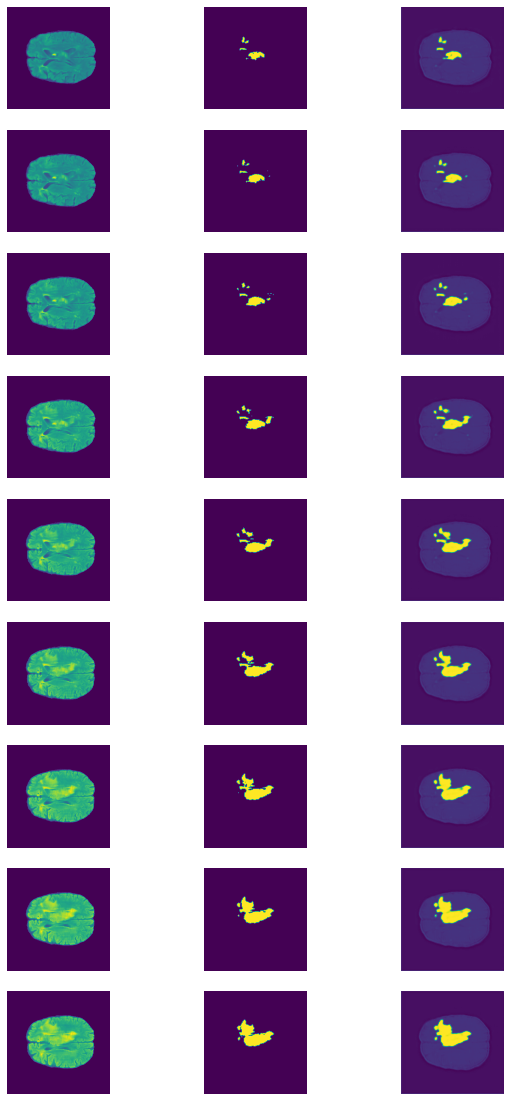

In [9]:
plt.figure(figsize = (10, 20))
for i in range(9):
    plt.subplot(9, 3, (3*i + 1))
    plt.imshow(x_temp[i, 0].detach().cpu())
    plt.axis("off")
    plt.subplot(9, 3, (3*i + 2))    
    plt.imshow(y[i, 0].detach().cpu())
    plt.axis("off")
    plt.subplot(9, 3, (3*i + 3))    
    plt.imshow(y_predicted[i, 0].detach().cpu())
    plt.axis("off")
plt.show()